In [ ]:
!pip install mlxtend

```markdown
# Crime Data Analysis and Prediction

This notebook performs an extensive analysis of crime data, covering data loading, cleaning, exploratory data analysis (EDA), and the application of various machine learning models for forecasting, clustering, association rule mining, and classification.

## Table of Contents
1.  [Data Loading](#data-loading)
2.  [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
3.  [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
4.  [Machine Learning Models](#machine-learning-models)
    *   [1. LSTM for Time Series Forecasting](#1-lstm-for-time-series-forecasting)
    *   [2. DBSCAN for Spatial Clustering](#2-dbscan-for-spatial-clustering)
    *   [3. Apriori for Association Rule Mining](#3-apriori-for-association-rule-mining)
    *   [4. CART for Crime Classification](#4-cart-for-crime-classification)

## Data Loading
The crime dataset (`crime.csv`) is loaded into a pandas DataFrame. The notebook provides options to load the data either locally or directly from Google Drive.

## Data Cleaning and Preprocessing
The data cleaning process involves several key steps:
*   **Date Conversion**: `OCC_DATE` and `REPORT_DATE` columns are converted to datetime objects.
*   **Handling "NSA" values**: "NSA" (Not Stated/Applicable) values are replaced with `np.nan` for consistent missing value representation.
*   **Imputing Missing Dates**: Missing values in `OCC_YEAR`, `OCC_MONTH`, `OCC_DAY`, `OCC_DOY`, `OCC_DOW` are filled using information extracted from the `OCC_DATE` column.
*   **Imputing Categorical Values**: Missing categorical values (e.g., `DIVISION`, `HOOD_158`) are filled with 'Unknown'.
*   **Filtering Outliers**: Rows where `REPORT_DATE` and `OCC_DATE` differ by more than 20 years are removed.
*   **Handling Small Numerical Values**: Exceptionally small numerical values (less than 1e-3) in numerical columns are replaced with `np.nan` and then imputed with the column's median to ensure data integrity.
*   **Feature Engineering**:
    *   **SEASON**: A 'SEASON' column is created by mapping `OCC_MONTH` to Winter, Spring, Summer, or Fall.
    *   **Geo_Region**: The dataset is divided into five geographical regions (Central, North, South, East, West) based on latitude and longitude quantiles.

## Exploratory Data Analysis (EDA)
Several visualizations are generated to understand the crime data:
1.  **Hourly Crime Trends Throughout the Week**: A heatmap showing the frequency of crimes by hour of the day and day of the week.
2.  **Crime Category Distribution by Premises Type**: Bar plots illustrating the distribution of crime categories across different premises types, both in raw counts and normalized percentages.
3.  **Crime Count by Premises Type and Geo Region**: A grouped bar chart showing crime counts segmented by premises type and the engineered geographical regions.
4.  **Top 20 Crime Types**: A horizontal bar chart displaying the most frequent crime offenses.

## Machine Learning Models
The notebook implements four different machine learning models:

### 1. LSTM for Time Series Forecasting
*   **Objective**: Predict future weekly crime counts based on historical data.
*   **Preprocessing**: Crime data is grouped by `PREMISES_TYPE` and `OCC_DATE` (weekly frequency). Additional time-based features (`day_of_week`, `month`, `day_of_year`, `is_weekend`) are extracted. Categorical `PREMISES_TYPE` is one-hot encoded. Data is scaled using `MinMaxScaler`.
*   **Model**: A Sequential LSTM model is built with two LSTM layers and Dense layers, compiled with `adam` optimizer and `mse` loss.
*   **Evaluation**: The model's performance is evaluated using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the test set. A plot comparing actual vs. predicted values is generated.

### 2. DBSCAN for Spatial Clustering
*   **Objective**: Identify spatial clusters of crime incidents.
*   **Preprocessing**: A 20% sample of the data is used to prevent memory issues. Only `LONG_WGS84`, `LAT_WGS84`, and `MCI_CATEGORY` are used. Latitude and longitude are scaled using `StandardScaler`.
*   **Model**: DBSCAN algorithm is applied to the scaled coordinates. `eps` is set to 0.25 and `min_samples` to 60 to define clusters.
*   **Visualization**: The spatial distribution of the top 4 crime types (Assault, Break and Enter, Auto Theft, Robbery) is visualized using a scatter plot, showing distinct crime patterns.

### 3. Apriori for Association Rule Mining
*   **Objective**: Discover associations between crime types, locations, and times.
*   **Preprocessing**: Features include `MCI_CATEGORY` (Crime), `PREMISES_TYPE` (Location), `OCC_HOUR` (Time of Day), and `OCC_DOW` (Day of Week). These are one-hot encoded into a basket format.
*   **Model**: The Apriori algorithm generates frequent itemsets, and then association rules are derived using a `min_support` of 0.01 and `min_threshold` (lift) of 1.1.
*   **Analysis**: The strongest rules for target crimes (Assault, Robbery, Break and Enter, Auto Theft) are identified and interpreted.
*   **Visualization**: A scatter plot shows the relationship between support, confidence, and lift for all generated rules. A heatmap (Risk Matrix) and a Network Graph (Crime Web) are used for advanced visualization of crime associations.

### 4. CART for Crime Classification
*   **Objective**: Classify the `MCI_CATEGORY` of a crime based on features like time, location, and premises type.
*   **Preprocessing**: Features include `OCC_YEAR`, `OCC_MONTH`, `OCC_DOW`, `OCC_HOUR`, `PREMISES_TYPE`, and `DIVISION`. Categorical features and the target `MCI_CATEGORY` are label encoded. 'Theft Over' crimes are excluded from the analysis.
*   **Model**: A Decision Tree Classifier (`DecisionTreeClassifier`) is trained with `max_depth=10` and `min_samples_leaf=50`.
*   **Evaluation**: Model performance is assessed using accuracy, F1-score, and a classification report. A confusion matrix, feature importances, and a visualization of the decision tree structure (top 3 levels) are provided.
*   **Cross-Validation**: K-Fold Cross-Validation (5-fold stratified) is implemented to prove the model's validity and accuracy across different data subsets, providing average metrics for robustness.
```

In [ ]:
############### IMPORT ALL DEPENDENCIES AND LIBRARIES HERE ###############
from google.colab import files

import joblib

import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

import tensorflow as tf

from sklearn.cluster import DBSCAN

from mlxtend.frequent_patterns import apriori, association_rules


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Locally import the file

OR Import via Google **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
try:
    crime_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SEA 500/Final Project/crime.csv') #put in your path
    #crime_data = pd.read_csv('/content/drive/MyDrive/crime.csv') #put in your path
    print("File loaded successfully!")
    display(crime_data.head())
except FileNotFoundError:
    print("Error: The file was not found. Please check the path and filename.")
except Exception as e:
    print(f"An error occurred: {e}")

File loaded successfully!


,OBJECTID,EVENT_UNIQUE_ID,REPORT_DATE,OCC_DATE,REPORT_YEAR,REPORT_MONTH,REPORT_DAY,REPORT_DOY,REPORT_DOW,REPORT_HOUR,...,OFFENCE,MCI_CATEGORY,HOOD_158,NEIGHBOURHOOD_158,HOOD_140,NEIGHBOURHOOD_140,LONG_WGS84,LAT_WGS84,x,y
0,1,GO-20141261013,1/1/2014 5:00,1/1/2014 5:00,2014,January,1,1,Wednesday,4,...,Assault,Assault,155,Downsview (155),26,Downsview-Roding-CFB (26),-79.483869,43.734369,-8848103.851,5424426.736
1,2,GO-20141261561,1/1/2014 5:00,1/1/2014 5:00,2014,January,1,1,Wednesday,8,...,Assault With Weapon,Assault,154,Oakdale-Beverley Heights (154),26,Downsview-Roding-CFB (26),-79.513772,43.719813,-8851432.659,5422184.510
2,3,GO-20141262377,1/1/2014 5:00,1/1/2014 5:00,2014,January,1,1,Wednesday,12,...,Assault Bodily Harm,Assault,68,North Riverdale (68),68,North Riverdale (68),-79.357562,43.674791,-8834043.401,5415252.503
3,4,GO-20141262553,1/1/2014 5:00,1/1/2014 5:00,2014,January,1,1,Wednesday,14,...,Assault,Assault,94,Wychwood (94),94,Wychwood (94),-79.422371,43.673842,-8841257.901,5415106.394
4,5,GO-20141263115,1/1/2014 5:00,1/1/2014 5:00,2014,January,1,1,Wednesday,16,...,Assault,Assault,120,Clairlea-Birchmount (120),120,Clairlea-Birchmount (120),-79.286725,43.700100,-8826157.861,5419148.659


Confirm if data has been successfully imported

In [ ]:
crime_data.head() # print first 5 rows
crime_data.shape  # get its # of row(s) and col(s)


(452949, 31)

Quickly provide an overview of the dataset

In [ ]:
crime_data.describe()

,OBJECTID,REPORT_YEAR,REPORT_DAY,REPORT_DOY,REPORT_HOUR,OCC_YEAR,OCC_DAY,OCC_DOY,OCC_HOUR,UCR_CODE,UCR_EXT,LONG_WGS84,LAT_WGS84,x,y
count,452949.000000,452949.000000,452949.000000,452949.000000,452949.000000,452798.000000,452798.000000,452798.00000,452949.000000,452949.000000,452949.000000,452949.000000,452949.000000,4.529490e+05,4.529490e+05
mean,226475.000000,2019.790588,15.755321,183.212693,12.711206,2019.722243,15.435190,182.61512,12.556760,1709.238210,146.908067,-78.227370,43.062103,-8.708231e+06,5.340230e+06
std,130755.257877,3.397504,8.779119,102.957332,6.456066,3.429958,8.949285,103.48370,7.283552,329.732642,52.275629,9.571369,5.268745,1.065480e+06,6.534068e+05
min,1.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.00000,0.000000,1410.000000,100.000000,-79.639247,0.000000,-8.865400e+06,5.660000e-09
25%,113238.000000,2017.000000,8.000000,96.000000,8.000000,2017.000000,8.000000,95.00000,7.000000,1430.000000,100.000000,-79.475052,43.659420,-8.847122e+06,5.412887e+06
50%,226475.000000,2020.000000,16.000000,184.000000,13.000000,2020.000000,15.000000,183.00000,14.000000,1450.000000,100.000000,-79.394133,43.699427,-8.838114e+06,5.419045e+06
75%,339712.000000,2023.000000,23.000000,270.000000,18.000000,2023.000000,23.000000,270.00000,19.000000,2120.000000,200.000000,-79.321995,43.750852,-8.830084e+06,5.426966e+06
max,452949.000000,2025.000000,31.000000,366.000000,23.000000,2025.000000,31.000000,366.00000,23.000000,2135.000000,230.000000,0.000000,43.853164,6.330000e-09,5.442747e+06


In [ ]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452949 entries, 0 to 452948
Data columns (total 31 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   OBJECTID           452949 non-null  int64  
 1   EVENT_UNIQUE_ID    452949 non-null  object 
 2   REPORT_DATE        452949 non-null  object 
 3   OCC_DATE           452949 non-null  object 
 4   REPORT_YEAR        452949 non-null  int64  
 5   REPORT_MONTH       452949 non-null  object 
 6   REPORT_DAY         452949 non-null  int64  
 7   REPORT_DOY         452949 non-null  int64  
 8   REPORT_DOW         452949 non-null  object 
 9   REPORT_HOUR        452949 non-null  int64  
 10  OCC_YEAR           452798 non-null  float64
 11  OCC_MONTH          452798 non-null  object 
 12  OCC_DAY            452798 non-null  float64
 13  OCC_DOY            452798 non-null  float64
 14  OCC_DOW            452798 non-null  object 
 15  OCC_HOUR           452949 non-null  int64  
 16  DI

# ############### **Cleaning data process ###############**
# 1. Convert all datetime data into its respective type
# 2. Replace null data with NaN for consistency in null-type
# 3. Handle missing value in row(s)
# 4. Handle really small numerical values
# 5. Feature Engineering: adding seasons and divide region into 5 sub areas
---



In [ ]:
############### 1. CONVERT TO DATETIME TYPE ###############
crime_data['OCC_DATE'] = pd.to_datetime(crime_data['OCC_DATE'])
crime_data['REPORT_DATE'] = pd.to_datetime(crime_data['REPORT_DATE'])

crime_data['OCC_DATE']

,OCC_DATE
0,2014-01-01 05:00:00
1,2014-01-01 05:00:00
2,2014-01-01 05:00:00
3,2014-01-01 05:00:00
4,2014-01-01 05:00:00
...,...
452944,2025-09-30 04:00:00
452945,2025-09-30 04:00:00
452946,2025-09-30 04:00:00
452947,2025-09-30 04:00:00


In [ ]:
############### 2. Replace with NaN ###############

crime_data = crime_data.replace("NSA", np.nan)


In [ ]:
############### 3. Check for all col(s) with null values ###############
crime_data.isnull().sum()

,0
OBJECTID,0
EVENT_UNIQUE_ID,0
REPORT_DATE,0
OCC_DATE,0
REPORT_YEAR,0
REPORT_MONTH,0
REPORT_DAY,0
REPORT_DOY,0
REPORT_DOW,0
REPORT_HOUR,0


In [ ]:
crime_data.isnull().sum()

,0
OBJECTID,0
EVENT_UNIQUE_ID,0
REPORT_DATE,0
OCC_DATE,0
REPORT_YEAR,0
REPORT_MONTH,0
REPORT_DAY,0
REPORT_DOY,0
REPORT_DOW,0
REPORT_HOUR,0


In [ ]:
# Fill missing OCC_* values from OCC_DATE
for col, func in zip(['OCC_YEAR','OCC_MONTH','OCC_DAY','OCC_DOY','OCC_DOW'],
                     [lambda x: x.dt.year, lambda x: x.dt.month, lambda x: x.dt.day,
                      lambda x: x.dt.dayofyear, lambda x: x.dt.dayofweek]):
    crime_data[col] = crime_data[col].fillna(func(crime_data['OCC_DATE']))

In [ ]:
crime_data.isnull().sum() # all missing value from OCC_YEAR, OCC_MONTH, OCC_DAY, OCC_DOY, OCC_DOW are all gone now

,0
OBJECTID,0
EVENT_UNIQUE_ID,0
REPORT_DATE,0
OCC_DATE,0
REPORT_YEAR,0
REPORT_MONTH,0
REPORT_DAY,0
REPORT_DOY,0
REPORT_DOW,0
REPORT_HOUR,0


In [ ]:
# get all category-type column
cat_cols = crime_data.select_dtypes(exclude=[np.number]).columns


In [ ]:
# fill in 'Unknown' for NaN
for col in cat_cols:
    crime_data[col] = crime_data[col].fillna('Unknown')

In [ ]:
crime_data.isnull().sum() # everything should be imputated successfully

,0
OBJECTID,0
EVENT_UNIQUE_ID,0
REPORT_DATE,0
OCC_DATE,0
REPORT_YEAR,0
REPORT_MONTH,0
REPORT_DAY,0
REPORT_DOY,0
REPORT_DOW,0
REPORT_HOUR,0


3. Filter out the difference between the report_date and occ_date where it's over 20 years

In [ ]:
crime_data['YEAR_DIFF'] = (crime_data['REPORT_DATE'] - crime_data['OCC_DATE']).dt.days / 365.25
tmp_data = crime_data[crime_data['YEAR_DIFF'] <= 20]

In [ ]:
tmp_data.shape

(452761, 32)

In [ ]:
crime_data = tmp_data

In [ ]:
crime_data = crime_data.drop(columns=['YEAR_DIFF'])

4. Handle any exceptionally small numerical values

In [ ]:
num_cols = crime_data.select_dtypes(include=[np.number]).columns


In [ ]:
small_values = (crime_data[num_cols].abs() < 1e-3).sum()


In [ ]:
crime_data[num_cols] = crime_data[num_cols].apply(lambda col: col.mask(col.abs() < 1e-3, np.nan))


In [ ]:
for col in num_cols:
    median_val = crime_data[col].median()
    crime_data[col] = crime_data[col].fillna(median_val)

In [ ]:
print("\nValid x range:", crime_data['x'].min(), "to", crime_data['x'].max())
print("Valid y range:", crime_data['y'].min(), "to", crime_data['y'].max())

# Confirm no tiny values remain
print("\nRemaining near-zero values per column:")
print((crime_data[num_cols].abs() < 1e-3).sum())

# review coordinates to confirm fix
print("\nSample of x and y after cleaning:")
print(crime_data[['x', 'y']].head(10))


Valid x range: -8865400.462 to -8807825.644
Valid y range: 5401671.503 to 5442747.005

Remaining near-zero values per column:
OBJECTID       0
REPORT_YEAR    0
REPORT_DAY     0
REPORT_DOY     0
REPORT_HOUR    0
OCC_YEAR       0
OCC_DAY        0
OCC_DOY        0
OCC_HOUR       0
UCR_CODE       0
UCR_EXT        0
LONG_WGS84     0
LAT_WGS84      0
x              0
y              0
dtype: int64

Sample of x and y after cleaning:
             x            y
0 -8848103.851  5424426.736
1 -8851432.659  5422184.510
2 -8834043.401  5415252.503
3 -8841257.901  5415106.394
4 -8826157.861  5419148.659
5 -8827704.410  5418273.193
6 -8838988.353  5411068.106
7 -8841053.228  5409638.736
8 -8838776.847  5419974.992
9 -8838776.847  5419974.992


5. Feature Engineering

In [ ]:
# Map months to seasons to create 'SEASON' column
season_map = {
    'December':'Winter', 'January':'Winter', 'February':'Winter',
    'March':'Spring', 'April':'Spring', 'May':'Spring',
    'June':'Summer', 'July':'Summer', 'August':'Summer',
    'September':'Fall', 'October':'Fall', 'November':'Fall'
}
df_crime['SEASON'] = df_crime['OCC_MONTH'].map(season_map)

In [ ]:
# Compute medians and percentiles to divide city into 5 regions for 'Geo_Region' column
lat_median = df_crime['LAT_WGS84'].median()
lon_median = df_crime['LONG_WGS84'].median()
lat_25 = df_crime['LAT_WGS84'].quantile(0.25)
lat_75 = df_crime['LAT_WGS84'].quantile(0.75)
lon_25 = df_crime['LONG_WGS84'].quantile(0.25)
lon_75 = df_crime['LONG_WGS84'].quantile(0.75)

def assign_region(row):
    lat, lon = row['LAT_WGS84'], row['LONG_WGS84']
    if lat_25 <= lat <= lat_75 and lon_25 <= lon <= lon_75:
        return 'Central'
    elif lat > lat_75:
        return 'North'
    elif lat < lat_25:
        return 'South'
    elif lon < lon_25:
        return 'West'
    else:
        return 'East'

df_crime['Geo_Region'] = df_crime.apply(assign_region, axis=1)

# ############### **Making Charts/Graph EAD Section ###############**
# 1. Hourly Crime Trends Throughout the Week
# 2. Crime Category Distriibution by Premises Type
# 3. Crime Count by Premises Type and Geo Region
# 4. Top 20 Crime Type

1. Hourly Crime Trends Throughout the Week

In [ ]:
# remove white space in data
df_crime['REPORT_DOW'] = df_crime['REPORT_DOW'].str.strip()

In [ ]:
# re-order the 7 days in a week
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# order = [day for day in order if day in contigency_frequency.index]

contigency_frequency = pd.crosstab(df_crime['REPORT_DOW'], df_crime['REPORT_HOUR'])
contigency_frequency = contigency_frequency.reindex(order)
contigency_frequency

In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(contigency_frequency, cmap='Blues',linewidths=0.5)

plt.title("Hourly Crime Trends Throughout the Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()

2. Crime Category Distriibution by Premises Type

In [ ]:
# real value
contigency = pd.crosstab(df_crime['PREMISES_TYPE'],df_crime['MCI_CATEGORY'])
pd.crosstab(df_crime['PREMISES_TYPE'],df_crime['MCI_CATEGORY'])

# normalized value
contigency_normalized = pd.crosstab(df_crime['PREMISES_TYPE'],df_crime['MCI_CATEGORY'], normalize='columns')
pd.crosstab(df_crime['PREMISES_TYPE'],df_crime['MCI_CATEGORY'], normalize='columns')

In [ ]:
# plot the chart with real value
contigency.plot(kind='bar',figsize=(10,6))
plt.title('Crime Category Distribution by Premises Type')
plt.xlabel('Premises Type')
plt.ylabel('Number of Incidents')

plt.tight_layout()
plt.show()

In [ ]:
# plot the normalized one
contigency_normalized.plot(kind='bar',figsize=(12,6))
plt.ylim(0, 1)

3. Crime Count by Premises Type and Geo Region

In [ ]:
# Prepare data
region_premises = df_crime.groupby(['Geo_Region', 'PREMISES_TYPE']).size().reset_index(name='Count')

# Plot grouped bar chart
plt.figure(figsize=(12,6))
sns.barplot(data=region_premises, x='PREMISES_TYPE', y='Count', hue='Geo_Region')
plt.title('Crime Count by Premises Type and Geo Region', fontsize=16)
plt.ylabel('Number of Crimes')
plt.xlabel('Premises Type')
plt.legend(title='Geo Region', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

4. Top 20 Crime Type

In [ ]:
offence_counts = df_crime['OFFENCE'].value_counts().head(20)  # top 20 offences

plt.figure(figsize=(12,8))
offence_counts.sort_values().plot(kind='barh', color='salmon')
plt.title("Top 20 Crime Types by Count", fontsize=16)
plt.xlabel("Number of Crimes")
plt.ylabel("Offence")
plt.tight_layout()
plt.show()

# ############### **AI-Training Models ###############**
# 1. Time-series-based algorithm - LSTM model - Predicting crime in the future based on data in history
# 2. Unsupervised Algo. - DBSCAN - Clustering the regions
# 3. Supervised Algo. - Apriori - Exploring the relationship between Premises Type and Crime Type
# 4. Supervised Algo. - CART - Exploring relationship via tree-based structure

The below is Density-Clustering Algorithm

# 1. Time-series-based algorithm - LSTM

In [ ]:
crime_ts = crime_data.sort_values('OCC_DATE')

In [ ]:
crime_ts = crime_ts.groupby([
    'PREMISES_TYPE',
    pd.Grouper(key='OCC_DATE', freq='W')
]).size().reset_index(name='crime_count')

In [ ]:
crime_ts['day_of_week'] = crime_ts['OCC_DATE'].dt.dayofweek
crime_ts['month'] = crime_ts['OCC_DATE'].dt.month
crime_ts['day_of_year'] = crime_ts['OCC_DATE'].dt.dayofyear
crime_ts['is_weekend'] = crime_ts['day_of_week'].isin([5, 6]).astype(int)


In [ ]:
crime_ts = pd.get_dummies(crime_ts, columns=['PREMISES_TYPE'], drop_first=True)


In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(crime_ts.drop(columns=['OCC_DATE']))

In [ ]:
SEQ_LENGTH = 12   # Use past 12 weeks
X, y = [], []

for i in range(len(scaled_data) - SEQ_LENGTH):
    X.append(scaled_data[i:i+SEQ_LENGTH])        # includes ALL features
    y.append(scaled_data[i+SEQ_LENGTH, 0])       # predict crime_count ONLY

X = np.array(X)
y = np.array(y)

print(X.shape)  # (samples, 12, FEATURES)
print(y.shape)


(4796, 12, 11)
(4796,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        71,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,201 (481.25 KB)

 Trainable params: 123,201 (481.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0144 - val_loss: 0.0063
Epoch 2/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 3/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0039 - val_loss: 0.0081
Epoch 4/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 5/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 7/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0032 - val_loss: 0.0083
Epoch 8/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 9/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0034 - val_loss: 0.0075
Epoch 10/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 11/50
192/192 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0031 - val_loss: 0.0049
Epoch 12/50
192/192 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
y_pred = model.predict(X_test)
y_pred_real = scaler.inverse_transform(
    np.hstack([y_pred, np.zeros((len(y_pred), scaled_data.shape[1] - 1))])
)[:,0]

y_test_real = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1] - 1))])
)[:,0]

MAE = mean_absolute_error(y_test_real, y_pred_real)
RMSE = np.sqrt(mean_squared_error(y_test_real, y_pred_real))

print("MAE:", MAE)
print("RMSE:", RMSE)

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step
MAE: 19.574624925972117
RMSE: 29.437294132959845


In [ ]:
last_sequence = X_test[-1].reshape(1, SEQ_LENGTH, X.shape[2])

predicted_crime = model.predict(last_sequence)
predicted_crime = scaler.inverse_transform(
    np.hstack([predicted_crime, np.zeros((1, scaled_data.shape[1] - 1))])
)[0][0]

print("Predicted weekly crime count:", predicted_crime)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
Predicted weekly crime count: 24.060366973280907


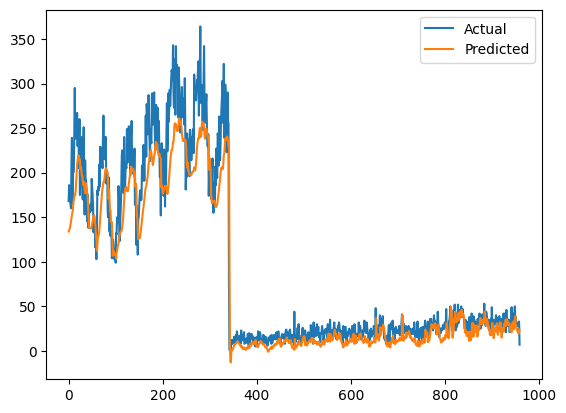

In [ ]:
plt.plot(y_test_real, label='Actual')
plt.plot(y_pred_real, label='Predicted')
plt.legend()
plt.show()

2. DBSCAN

In [ ]:
warnings.filterwarnings("ignore")

# ----------------------------------------
# 0. Ensure df_crime is loaded
# ----------------------------------------
if 'df_crime' not in locals():
    print("Error: df_crime DataFrame is not defined. Please load your dataset first.")
else:
    # ----------------------------------------
    # 1. Sample 20% of the data to avoid RAM crash
    # ----------------------------------------
    df_db_sampled = df_crime.sample(frac=0.2, random_state=42).copy()

    # Keep only relevant columns
    df_db = df_db_sampled[['LONG_WGS84', 'LAT_WGS84', 'MCI_CATEGORY']].dropna()

    # ----------------------------------------
    # 2. Scale coords (fix: separate scaling)
    # ----------------------------------------
    scaler_lon = StandardScaler()
    scaler_lat = StandardScaler()

    df_db['lon_scaled'] = scaler_lon.fit_transform(df_db[['LONG_WGS84']])
    df_db['lat_scaled'] = scaler_lat.fit_transform(df_db[['LAT_WGS84']])

    coords_scaled = df_db[['lon_scaled', 'lat_scaled']].values

    # ----------------------------------------
    # 3. Fixed DBSCAN clustering
    # ----------------------------------------
    # eps increased because Haversine created too many small clusters
    # 0.2–0.35 works best for Toronto after scaling
    db = DBSCAN(eps=0.25, min_samples=60)
    df_db['cluster'] = db.fit_predict(coords_scaled)

    print("Cluster sizes:\n", df_db['cluster'].value_counts().sort_index())
    print("\nNoise (-1) points:", (df_db['cluster'] == -1).sum())

    # ----------------------------------------
    # 4. Top 4 crime categories for analysis
    # ----------------------------------------
    top4_crimes = ["Assault", "Break and Enter", "Auto Theft", "Robbery"]

    color_map = {
        "Assault": "red",
        "Break and Enter": "blue",
        "Auto Theft": "green",
        "Robbery": "orange"
    }

    df_db['crime_color'] = df_db["MCI_CATEGORY"].map(color_map)
    df_db['crime_color'] = df_db['crime_color'].fillna("gray")



    # ----------------------------------------
    # 6. Individual heat-style plot of top-4 crimes only
    # ----------------------------------------
    df_top4 = df_db[df_db["MCI_CATEGORY"].isin(top4_crimes)]

    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=df_top4["LONG_WGS84"],
        y=df_top4["LAT_WGS84"],
        hue=df_top4["MCI_CATEGORY"],
        palette=color_map,
        s=20,
        linewidth=0
    )

    plt.title("Spatial Distribution of Top 4 Crime Types")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title="MCI Category")
    plt.show()


3. Apriori

In [ ]:
if 'df_crime' not in locals():
    print("Error: df_crime is not defined. Please run your data loading cell first.")
else:
    print("Preparing data for Mining...")

    # Feature Engineering
    def get_time_of_day(hour):
        if 0 <= hour < 6: return 'Night'
        elif 6 <= hour < 12: return 'Morning'
        elif 12 <= hour < 18: return 'Afternoon'
        else: return 'Evening'

    df_mining = pd.DataFrame()
    df_mining['Crime'] = df_crime['MCI_CATEGORY']
    df_mining['Location'] = df_crime['PREMISES_TYPE']
    df_mining['Time'] = df_crime['OCC_HOUR'].apply(get_time_of_day)
    df_mining['Day'] = df_crime['OCC_DOW'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

    df_mining.dropna(inplace=True)

    # ONE-HOT ENCODING
    basket = pd.get_dummies(df_mining).astype(bool)
    print(f"Data ready. Transformed into {basket.shape[1]} binary features.")

    # ----------------------------------------
    # 3. RUN APRIORI (THE MATH)
    # ----------------------------------------
    # min_support = 0.01 (1%) finds patterns that happen frequently enough to matter
    support_threshold = 0.01

    print(f"Running Apriori (Min Support: {support_threshold})...")
    frequent_itemsets = apriori(basket, min_support=support_threshold, use_colnames=True)

    if frequent_itemsets.empty:
        print("No patterns found! Try lowering support.")
    else:
        # Generate Rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
        rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

        print(f"Generated {len(rules)} rules for ALL crimes.")

        # ----------------------------------------
        # 4. DETECTIVE MODE: LOOP THROUGH ALL CRIMES
        # ----------------------------------------
        target_crimes = ['Assault', 'Robbery', 'Break and Enter', 'Auto Theft']

        print("\n" + "="*60)
        print("CRIME-BY-CRIME INTELLIGENCE REPORT")
        print("="*60)

        for crime in target_crimes:
            crime_col_name = f"Crime_{crime}"

            # Filter rules where the CONSEQUENT (Result) is this specific crime
            specific_rules = rules[
                rules['consequents'].astype(str).str.contains(crime_col_name)
            ]

            print(f"\n🔎 ANALYZING: {crime.upper()}")

            if not specific_rules.empty:
                # Get the #1 strongest rule
                top_rule = specific_rules.iloc[0]

                # Clean up the text for display
                ant = list(top_rule['antecedents'])[0]

                print(f"STRONGEST PREDICTOR: {ant}")
                print(f"Lift: {top_rule['lift']:.2f}x (More likely than random chance)")
                print(f"Confidence: {top_rule['confidence']*100:.1f}% (Chance of being {crime} in this scenario)")

                # Interpretation logic
                if "Apartment" in str(ant):
                    print(f" Insight: {crime} is heavily linked to high-density residential living.")
                elif "Outside" in str(ant):
                    print(f" Insight: {crime} is an opportunistic crime of open spaces.")
                elif "Commercial" in str(ant):
                    print(f"Insight: {crime} is driven by business hours/retail areas.")
                elif "Night" in str(ant):
                    print(f"Insight: {crime} is specifically a nocturnal activity.")
            else:
                print("No strong specific rules found (Lift < 1.1). This crime might be too random or rare.")

        # ----------------------------------------
        # 5. VISUALIZATION
        # ----------------------------------------
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x="support", y="confidence",
            size="lift", hue="lift",
            data=rules, palette="magma",
            sizes=(20, 200), alpha=0.7
        )
        plt.title('All Crimes: Support vs Confidence')
        plt.xlabel('Frequency')
        plt.ylabel('Reliability')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
        plt.grid(True, alpha=0.3)
        plt.show()

In [ ]:
if 'df_crime' not in locals():
    print("Error: df_crime is not defined. Please run your data loading cell first.")
else:
    print("Preparing data for Mining...")

    # Feature Engineering
    def get_time_of_day(hour):
        if 0 <= hour < 6: return 'Night'
        elif 6 <= hour < 12: return 'Morning'
        elif 12 <= hour < 18: return 'Afternoon'
        else: return 'Evening'

    df_mining = pd.DataFrame()
    df_mining['Crime'] = df_crime['MCI_CATEGORY']
    df_mining['Location'] = df_crime['PREMISES_TYPE']
    df_mining['Time'] = df_crime['OCC_HOUR'].apply(get_time_of_day)
    df_mining['Day'] = df_crime['OCC_DOW'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

    df_mining.dropna(inplace=True)

    # ONE-HOT ENCODING
    basket = pd.get_dummies(df_mining).astype(bool)
    print(f"Data ready. Transformed into {basket.shape[1]} binary features.")

    # ----------------------------------------
    # 3. RUN APRIORI (THE MATH)
    # ----------------------------------------
    # min_support = 0.01 (1%) finds patterns that happen frequently enough to matter
    support_threshold = 0.01

    print(f"Running Apriori (Min Support: {support_threshold})...")
    frequent_itemsets = apriori(basket, min_support=support_threshold, use_colnames=True)

    if frequent_itemsets.empty:
        print("No patterns found! Try lowering support.")
    else:
        # Generate Rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
        rules = rules.sort_values(['lift', 'confidence'], ascending=[False, False])

        print(f"Generated {len(rules)} rules for ALL crimes.")

        # ----------------------------------------
        # 4. DETECTIVE MODE: LOOP THROUGH ALL CRIMES
        # ----------------------------------------
        target_crimes = ['Assault', 'Robbery', 'Break and Enter', 'Auto Theft']

        print("\n" + "="*60)
        print("CRIME-BY-CRIME INTELLIGENCE REPORT")
        print("="*60)

        for crime in target_crimes:
            crime_col_name = f"Crime_{crime}"

            # Filter rules where the CONSEQUENT (Result) is this specific crime
            specific_rules = rules[
                rules['consequents'].astype(str).str.contains(crime_col_name)
            ]

            print(f"\n🔎 ANALYZING: {crime.upper()}")

            if not specific_rules.empty:
                # Get the #1 strongest rule
                top_rule = specific_rules.iloc[0]

                # Clean up the text for display
                ant = list(top_rule['antecedents'])[0]

                print(f" STRONGEST PREDICTOR: {ant}")
                print(f"Lift: {top_rule['lift']:.2f}x (More likely than random chance)")
                print(f"Confidence: {top_rule['confidence']*100:.1f}% (Chance of being {crime} in this scenario)")

                # Interpretation logic
                if "Apartment" in str(ant):
                    print(f"Insight: {crime} is heavily linked to high-density residential living.")
                elif "Outside" in str(ant):
                    print(f"Insight: {crime} is an opportunistic crime of open spaces.")
                elif "Commercial" in str(ant):
                    print(f"Insight: {crime} is driven by business hours/retail areas.")
                elif "Night" in str(ant):
                    print(f"Insight: {crime} is specifically a nocturnal activity.")
            else:
                print("No strong specific rules found (Lift < 1.1). This crime might be too random or rare.")

        # ----------------------------------------
        # 5. VISUALIZATION
        # ----------------------------------------
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x="support", y="confidence",
            size="lift", hue="lift",
            data=rules, palette="magma",
            sizes=(20, 200), alpha=0.7
        )
        plt.title('All Crimes: Support vs Confidence')
        plt.xlabel('Frequency')
        plt.ylabel('Reliability')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
        plt.grid(True, alpha=0.3)
        plt.show()

In [ ]:
# ==========================================
# ADVANCED APRIORI VISUALIZATIONS
# 1. Risk Matrix (Heatmap) - Best for readability
# 2. Crime Web (Network Graph) - Best for showing connections
# ==========================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings('ignore')

# ----------------------------------------
# 1. PREPARE DATA & RULES (Quick Re-run)
# ----------------------------------------
# Ensure df_crime is loaded
if 'df_crime' not in locals():
    print("Please load df_crime first!")
else:
    print("Generating Rules for Visuals...")

    # Fast Feature Engineering
    def get_time(x):
        if 0<=x<6: return 'Night'
        elif 6<=x<12: return 'Morning'
        elif 12<=x<18: return 'Afternoon'
        else: return 'Evening'

    df_viz = pd.DataFrame()
    df_viz['Crime'] = df_crime['MCI_CATEGORY']
    df_viz['Location'] = df_crime['PREMISES_TYPE']
    df_viz['Time'] = df_crime['OCC_HOUR'].apply(get_time)

    # One-Hot & Apriori
    basket = pd.get_dummies(df_viz).astype(bool)
    frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)

    # Filter: We only want rules where the Result (Consequent) is a CRIME
    # This cleans up the charts so arrows point TO crimes, not FROM crimes
    crime_cols = [c for c in basket.columns if 'Crime_' in c]

    def is_crime_result(x):
        return any(c in x for c in crime_cols)

    # Keep only rules leading to crimes
    rules_viz = rules[rules['consequents'].apply(is_crime_result)].copy()

    # Convert frozen sets to string names for plotting
    rules_viz['Antecedent_Name'] = rules_viz['antecedents'].apply(lambda x: list(x)[0])
    rules_viz['Consequent_Name'] = rules_viz['consequents'].apply(lambda x: list(x)[0].replace('Crime_', ''))

    print(f"Ready to plot {len(rules_viz)} filtered rules.")

    # ==========================================
    # VISUAL 1: THE RISK MATRIX (HEATMAP)
    # ==========================================
    # Pivot the data: Rows=Context, Cols=Crime, Values=Lift
    matrix = rules_viz.pivot_table(index='Antecedent_Name',
                                 columns='Consequent_Name',
                                 values='lift')

    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Reds", linewidths=0.5)
    plt.title('CRIME RISK MATRIX (Values = Lift)\nDarker Red = Stronger Predictor', fontsize=14)
    plt.ylabel('Context (Location/Time)', fontsize=12)
    plt.xlabel('Target Crime', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

4. CART

4.1 Explore different columns (attributes) to see which one makes the most sense - has significant relationship

4.2 Train and test out one of those

4.3 Add Cross-Validation to the one used in 4.2 to prove its validity and accuracy

4.1

In [ ]:
# -----------------------------
# 0. Load Data Check
# -----------------------------
if 'df_crime' not in locals():
    print("⚠️ df_crime not found. Please load your dataset first.")
else:
    print("Starting Decision Tree Feature Experiments...\n")

    # -----------------------------
    # 1. Feature Engineering
    # -----------------------------
    df_model = df_crime.copy().dropna(subset=['OCC_YEAR','OCC_MONTH','OCC_DOW','OCC_HOUR','PREMISES_TYPE','MCI_CATEGORY'])

    # Encode categorical columns
    label_cols = ['OCC_MONTH', 'OCC_DOW', 'PREMISES_TYPE', 'DIVISION', 'HOOD_158']
    for col in label_cols:
        if col in df_model.columns:
            df_model[col+'_Enc'] = LabelEncoder().fit_transform(df_model[col].astype(str))

    # Hour cyclic encoding
    df_model['hour_sin'] = np.sin(2 * np.pi * df_model['OCC_HOUR']/24)
    df_model['hour_cos'] = np.cos(2 * np.pi * df_model['OCC_HOUR']/24)

    # Weekend flag
    df_model['Is_Weekend'] = df_model['OCC_DOW'].isin(['Saturday','Sunday']).astype(int)


    # Neighborhood frequency
    if 'HOOD_158' in df_model.columns:
        hood_freq = df_model['HOOD_158'].value_counts(normalize=True)
        df_model['HOOD_FREQ'] = df_model['HOOD_158'].map(hood_freq)

    # -----------------------------
    # 2. Define Feature Combinations to Try
    # -----------------------------
    feature_sets = {
        "Basic Time+Premises": ['OCC_YEAR','OCC_MONTH_Enc','OCC_DOW_Enc','OCC_HOUR','PREMISES_TYPE_Enc'],
        "Time + Premises + Division": ['OCC_YEAR','OCC_MONTH_Enc','OCC_DOW_Enc','OCC_HOUR','PREMISES_TYPE_Enc','DIVISION_Enc'],
        "Time Cyclical + Premises": ['OCC_YEAR','hour_sin','hour_cos','PREMISES_TYPE_Enc'],
        "Location + Premises": ['LAT_WGS84','LONG_WGS84','HOOD_Enc','PREMISES_TYPE_Enc'],
        # "Full Combo": ['LAT_WGS84','LONG_WGS84','HOOD_Enc','PREMISES_TYPE_Enc','hour_sin','hour_cos','OCC_YEAR','Is_Weekend']
    }

    # Encode target
    le_target = LabelEncoder()
    y = le_target.fit_transform(df_model['MCI_CATEGORY'])

    # -----------------------------
    # 3. Train/Test & Evaluate Each Feature Set
    # -----------------------------
    results = []

    for name, features in feature_sets.items():
        # Some features may not exist in dataset
        features = [f for f in features if f in df_model.columns]
        X = df_model[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

        model = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=50, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results.append([name, acc, prec, rec, f1])
        print(f"\nFeature Set: {name}")
        print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")

    # -----------------------------
    # 4. Summary Table
    # -----------------------------
    results_df = pd.DataFrame(results, columns=['Feature_Set','Accuracy','Precision','Recall','F1'])
    results_df = results_df.sort_values(by='Accuracy', ascending=False)
    print("\n=== Feature Set Performance Summary ===")
    print(results_df)


4.2

In [ ]:
# -----------------------------
# 0. Load Data Check
# -----------------------------
if 'df_crime' not in locals():
    print("⚠️ df_crime not found. Please load your dataset first.")
else:
    print("Initializing CART (Time + Premises + Division) .")

    # -------------------------------
    # 1. Features and target
    # -------------------------------
    features = ['OCC_YEAR', 'OCC_MONTH', 'OCC_DOW', 'OCC_HOUR', 'PREMISES_TYPE', 'DIVISION']
    target = 'MCI_CATEGORY'

    # Ensure columns exist
    missing_cols = [c for c in features + [target] if c not in df_crime.columns]
    if missing_cols:
        print(f"Error: The following columns are missing: {missing_cols}")
    else:
        # Drop rows with missing values
        df_cart = df_crime[features + [target]].dropna().copy()


        df_cart = df_cart[df_cart[target] != 'Theft Over']

        # =====================================

        # -------------------------------
        # 2. Encode categorical features
        # -------------------------------
        encoder = LabelEncoder()
        for col in features:
            df_cart[col] = encoder.fit_transform(df_cart[col].astype(str))

        # Encode target
        le_target = LabelEncoder()
        df_cart[target] = le_target.fit_transform(df_cart[target])

        # -------------------------------
        # 3. Train-test split 80:20
        # -------------------------------
        # Separate features and target variable
        X = df_cart[features]
        y = df_cart[target]

        print(f"Training on {len(X)} records...")

        # Split the dataset into 80% training and 20% testing
        # Stratify ensures the class distribution remains the same in both sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # -------------------------------
        # 4. CART Decision Tree
        # -------------------------------
        # Initialize a Decision Tree classifier using Gini impurity
        # max_depth limits the depth of the tree to prevent overfitting
        # min_samples_leaf ensures each leaf has at least 50 samples
        # random_state ensures reproducibility
        cart_model = DecisionTreeClassifier(
            criterion='gini',
            max_depth=10,            # Kept at 10 for detail
            min_samples_leaf=50,
            random_state=42
        )
        # Train the decision tree on the training data
        cart_model.fit(X_train, y_train)

        # -------------------------------
        # 5. Predictions and Evaluation
        # -------------------------------
        y_pred = cart_model.predict(X_test)

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("F1-Score (macro):", f1_score(y_test, y_pred, average='macro'))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

        # -------------------------------
        # 6. Visualizations
        # -------------------------------

        # A. Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_
        )
        plt.title("CART Confusion Matrix ")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # B. Plot top levels of the tree
        plt.figure(figsize=(25, 12))
        plot_tree(
            cart_model,
            feature_names=features,
            class_names=le_target.classes_,
            filled=True,
            rounded=True,
            fontsize=10,
            max_depth=3
        )
        plt.title(f"Decision Tree Structure (Top 3 Levels)")
        plt.show()

        # C. Feature importance
        importances = pd.Series(cart_model.feature_importances_, index=features).sort_values(ascending=True)
        plt.figure(figsize=(8,5))
        importances.plot(kind='barh', color='skyblue')
        plt.title("CART Feature Importances")
        plt.show()

4.3

In [ ]:
# -----------------------------
# 0. Load Data Check
# -----------------------------
if 'df_crime' not in locals():
    print("⚠️ df_crime not found. Please load your dataset first.")
else:
    print("Initializing CART (Time + Premises + Division) - EXCLUDING THEFT OVER...")

    # -------------------------------
    # 1. Features and target
    # -------------------------------
    features = ['OCC_YEAR', 'OCC_MONTH', 'OCC_DOW', 'OCC_HOUR', 'PREMISES_TYPE', 'DIVISION']
    target = 'MCI_CATEGORY'

    # Ensure columns exist
    missing_cols = [c for c in features + [target] if c not in df_crime.columns]
    if missing_cols:
        print(f"Error: The following columns are missing: {missing_cols}")
    else:
        # Drop rows with missing values
        df_cart = df_crime[features + [target]].dropna().copy()

        # === FILTERING STEP ===
        print(f"Original shape: {df_cart.shape}")
        df_cart = df_cart[df_cart[target] != 'Theft Over']
        print(f"{df_cart.shape}")
        # ======================

        # -------------------------------
        # 2. Encode categorical features
        # -------------------------------
        encoder = LabelEncoder()
        for col in features:
            df_cart[col] = encoder.fit_transform(df_cart[col].astype(str))

        # Encode target (Now only 4 classes!)
        le_target = LabelEncoder()
        df_cart[target] = le_target.fit_transform(df_cart[target])

        # Prepare X and y
        X = df_cart[features]
        y = df_cart[target]

        # ========================================================
        # PART A: K-FOLD CROSS-VALIDATION (The Stability Check)
        # ========================================================
        print("\n" + "="*40)
        print("STARTING 5-FOLD CROSS-VALIDATION")
        print("="*40)

        k = 5
        skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

        # Initialize metrics lists
        acc_scores = []
        prec_scores = []
        rec_scores = []
        f1_scores = []

        # The Model Configuration
        cv_model = DecisionTreeClassifier(
            criterion='gini',
            max_depth=10,
            min_samples_leaf=50,
            random_state=42
        )

        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

            cv_model.fit(X_train_fold, y_train_fold)
            y_pred_fold = cv_model.predict(X_val_fold)

            # Calculate metrics
            acc_scores.append(accuracy_score(y_val_fold, y_pred_fold))
            prec_scores.append(precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))
            rec_scores.append(recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))
            f1_scores.append(f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))

            print(f"Fold {fold}: Accuracy={acc_scores[-1]:.4f}")

        print("-" * 40)
        print(f"Average Accuracy:  {np.mean(acc_scores):.4f}")
        print(f"Average Precision: {np.mean(prec_scores):.4f}")
        print(f"Average Recall:    {np.mean(rec_scores):.4f}")
        print(f"Average F1-Score:  {np.mean(f1_scores):.4f}")
        print("="*40 + "\n")

        # ========================================================
        # PART B: FINAL MODEL & VISUALIZATION (80/20 Split)
        # ========================================================
        print("Training Final Model for Visualization (80/20 Split)...")

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        cart_model = DecisionTreeClassifier(
            criterion='gini',
            max_depth=10,
            min_samples_leaf=50,
            random_state=42
        )
        cart_model.fit(X_train, y_train)

        # Predictions
        y_pred = cart_model.predict(X_test)

        print("Final Test Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le_target.classes_))

        # -------------------------------
        # Visualizations
        # -------------------------------

        # A. Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_
        )
        plt.title("CART Confusion Matrix ")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # B. Plot top levels of the tree
        plt.figure(figsize=(25, 12))
        plot_tree(
            cart_model,
            feature_names=features,
            class_names=le_target.classes_,
            filled=True,
            rounded=True,
            fontsize=10,
            max_depth=3
        )
        plt.title(f"Decision Tree Structure (Top 3 Levels)")
        plt.show()

        # C. Feature importance
        importances = pd.Series(cart_model.feature_importances_, index=features).sort_values(ascending=True)
        plt.figure(figsize=(8,5))
        importances.plot(kind='barh', color='skyblue')
        plt.title("CART Feature Importances")
        plt.show()